## This Jupyter Notebook contains ML algorithms implemented to detect endometriosis using self-reported patient data (No hyperparameter tuning)

### Machine Learning Algorithms:
- Logistic Regression
- Random Forest
- XGBoost 
- Decision Tree
- Support Vector Machine (SVM)
- Adaboost

In [1]:
## Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay

## Model Imports
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

## Feature Engineering
from sklearn.feature_selection import mutual_info_classif, chi2, SequentialFeatureSelector
from sklearn.decomposition import PCA


warnings.filterwarnings('ignore')  

# Methods
## Feature Engineering (In Analysis Code)
- Correlation Matrix
- Feature Importance 
- Chi-Square Test

## Feature Selection 
- Forward Feature Selection
- Backward Feature Selection
- PCA

## Evaluation
- Accuracy, Precision, Recall, F1-Score, ROC AUC, Standard Dev, Confusion Matrix
- ROC Curve & Precision-Recall Curve

In [2]:
## feature selection methods

def apply_ffs(model, xtrain, xtest, ytrain, x):
    print("--------------- Applying FFS ---------------")
    # Apply forward feature selection 
    sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward')
    Xtrain_selected = sfs.fit_transform(xtrain, ytrain)
    Xtest_selected = sfs.transform(xtest)

    # Get the indices of selected features
    selected_feature_indices = sfs.get_support(indices=True)

    # Get the names of selected features
    selected_feature_names = [x[i] for i in selected_feature_indices]

    print(F"\nFeatures selected by Forward Feature Selection: {Xtrain_selected.shape[1]}")
    print(F"\nFeatures selected by Forward Feature Selection: {selected_feature_names}")
    
    return Xtrain_selected, Xtest_selected 

def apply_bfs(model, xtrain, xtest, ytrain, x):
    print("--------------- Applying BFS ---------------")
    # Apply backward feature selection 
    sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='backward')
    Xtrain_selected = sfs.fit_transform(xtrain, ytrain)
    Xtest_selected = sfs.transform(xtest)

    # Get the indices of selected features
    selected_feature_indices = sfs.get_support(indices=True)

    # Get the names of selected features
    selected_feature_names = [x[i] for i in selected_feature_indices]

    print(F"\nFeatures selected by Backward Feature Selection: {Xtrain_selected.shape[1]}")
    print(F"\nFeatures selected by Backward Feature Selection: {selected_feature_names}")
    
    return Xtrain_selected, Xtest_selected 

def apply_pca(xtrain, xtest, x, components):
    print("--------------- Applying PCA ---------------")

    pca = PCA(n_components = components) 

    Xtrain_pca = pca.fit_transform(xtrain)
    Xtest_pca = pca.transform(xtest)

    #get number of components
    components = pca.components_
    
    # Identifying top contributing features for each principal component
    top_features_per_component = {}
    for i, component in enumerate(components):
        # Getting indices of top contributing features for this component
        top_feature_indices = np.argsort(-np.abs(component))[:3]
        # Mapping indices to feature names
        top_features = [x[idx] for idx in top_feature_indices]
        top_features_per_component[i] = top_features
        
    print(f"Number of Principal Components: {pca.n_components_}")
    for component, features in top_features_per_component.items():
        print(f"Component {component}: {features}")
    
    return Xtrain_pca, Xtest_pca

In [12]:
## evaluation functions 

def evaluate(ytest, ypred, model, xtrain, ytrain):
    
    accuracy = accuracy_score(ytest, ypred)
    precision = precision_score(ytest, ypred)
    recall = recall_score(ytest, ypred)
    f1score = f1_score(ytest, ypred)
    auc = roc_auc_score(ytest, ypred)
    cross_val = cross_val_score(model, xtrain, ytrain, scoring='accuracy', cv=5)
    std_dev = cross_val.std()
    conf_matrix = confusion_matrix(ytest, ypred)
    
    print("\n--------------- Evaluation ---------------")
    print(f'Accuracy: {accuracy:.3}')
    print(f'Precision: {precision:.3}')
    print(f'Recall: {recall:.3}')
    print(f'F1 Score: {f1score:.3}')
    print(f'ROC AUC: {auc:.3}')
    print(f'Standard Deviaiton (Accuracy): {std_dev:.3}')
    #print(f'\nConfusion Matrix: \n {conf_matrix}')
    print(f'\nClassification Report: ')
    print(classification_report(ytest, ypred, target_names=['0 - Negative', '1 - Positive']))
    #print(f'\nConfusion Matrix: \n {conf_matrix}')
    print("\n--------------- Visual Evaluation ---------------")
    disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred, cmap = 'cool')
    #disp.plot()
    fig = disp.figure_
    fig.set_figwidth(14)
    fig.set_figheight(5) 
    fig.suptitle('Confusion Matrix', fontsize = 15)
    plt.show()
    
    plot_roc_and_pr_curve(ytest, ypred)
    
    return accuracy, precision, recall, f1score, auc, std_dev
    
def plot_roc_and_pr_curve(ytrue, yscores):
    fpr, tpr, _ = roc_curve(ytrue, yscores)
    roc_auc = auc(fpr, tpr)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    
    ax[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    ax[0].legend(loc="lower right")
    #ax[0].show()
    
    precision, recall, _ = precision_recall_curve(ytrue, yscores)
    ax[1].step(recall, precision, where='post', color='b', alpha=0.7)
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall Curve')
    
    fig.suptitle('\nROC Curve & Precision-Recall Curve', fontsize = 15)
    plt.tight_layout() 
    plt.show()

# Main Code

In [4]:
data = pd.read_csv('../processed_data/patient_data.csv')
print("Shape: ", data.shape)
data.head()

Shape:  (886, 59)


,heavy_or_extreme_menstrual_bleeding,menstrual_pain_(dysmenorrhea),painful_or_burning_pain_during_sex_(dyspareunia),pelvic_pain,irregular_or_missed_periods,cramping,abdominal_pain_or_pressure,back_pain,painful_bowel_movements,nausea,...,fever,hormonal_problems,bloating,feeling_sick,decreased_energy_or_exhaustion,abdominal_cramps_during_intercourse,insomnia_or_sleeplessness,acne_or_pimples,loss_of_appetite,endometriosis_yn
0,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,1,0,0,0,1
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,1,1,0,0,1,1
2,0,1,0,1,1,1,0,1,0,1,...,0,0,1,1,1,0,1,0,0,1
3,1,0,0,0,0,1,1,1,0,0,...,0,0,1,0,1,0,0,0,0,1
4,0,1,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
X = data.drop('endometriosis_yn', axis = 1)
y = data[['endometriosis_yn']]

In [6]:
X.head()

,heavy_or_extreme_menstrual_bleeding,menstrual_pain_(dysmenorrhea),painful_or_burning_pain_during_sex_(dyspareunia),pelvic_pain,irregular_or_missed_periods,cramping,abdominal_pain_or_pressure,back_pain,painful_bowel_movements,nausea,...,abnormal_uterine_bleeding,fever,hormonal_problems,bloating,feeling_sick,decreased_energy_or_exhaustion,abdominal_cramps_during_intercourse,insomnia_or_sleeplessness,acne_or_pimples,loss_of_appetite
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,1,1,1,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,1
2,0,1,0,1,1,1,0,1,0,1,...,0,0,0,1,1,1,0,1,0,0
3,1,0,0,0,0,1,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,1,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
y.head()

,endometriosis_yn
0,1
1,1
2,1
3,1
4,1


In [8]:
Xtrain, Xtest ,ytrain ,ytest = train_test_split(X, y, test_size=0.25, random_state=0)

In [9]:
print(Xtrain.shape)
print(Xtest.shape)

(664, 58)
(222, 58)


In [10]:
## For results

model_results = pd.DataFrame({'Metrics':['Accuracy', 'Precision', 'Recall', 'F1Score', 'ROC AUC', 'Standard Dev']})
model_results.head()

,Metrics
0,Accuracy
1,Precision
2,Recall
3,F1Score
4,ROC AUC


# Model Development
## Logistic Regression 
### Base Model


--------------- Evaluation ---------------
Accuracy: 0.946
Precision: 0.956
Recall: 0.94
F1 Score: 0.948
ROC AUC: 0.946
Standard Deviaiton (Accuracy): 0.00824

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.94      0.95      0.94       106
1 - Positive       0.96      0.94      0.95       116

    accuracy                           0.95       222
   macro avg       0.95      0.95      0.95       222
weighted avg       0.95      0.95      0.95       222


--------------- Visual Evaluation ---------------


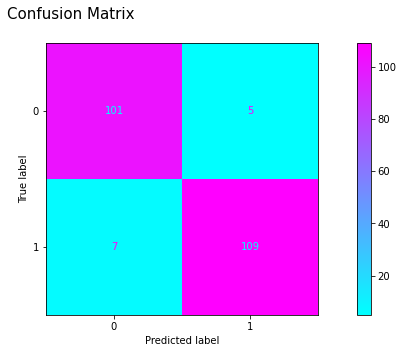

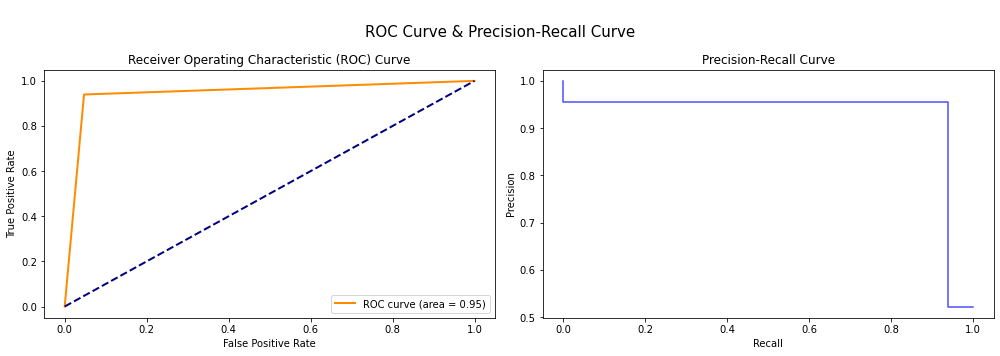

In [14]:
logistic_regression_model = LogisticRegression(max_iter = 10000)

logistic_regression_model.fit(Xtrain, ytrain)
ypred = logistic_regression_model.predict(Xtest)

results = evaluate(ytest, ypred, logistic_regression_model, Xtrain, ytrain)

model_results['Logistic Regression'] = results
#model_results

### Wrapper Method: Forward Feature Selection

--------------- LR FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'irregular_or_missed_periods', 'abdominal_pain_or_pressure', 'infertility', 'painful_cramps_during_period', 'long_menstruation', 'constipation_or_chronic_constipation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'syncope_(fainting,_passing_out)', 'mood_swings', 'depression', 'bleeding', 'fertility_issues', 'ovarian_cysts', 'constant_bleeding', 'digestive_or_gi_problems', 'anaemia_or_iron_deficiency', 'vaginal_painorpressure', 'bowel_pain', 'anxiety', 'dizziness', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'decreased_energy_or_exhaustion', 'abdominal_cramps_during_intercourse', 'acne_or_pimples', 'loss_of_appetite']
--------------- Model Training ---------------

--------------- Evaluation --------

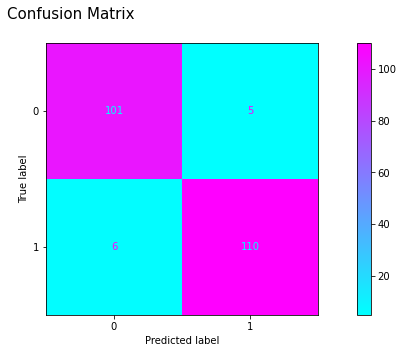

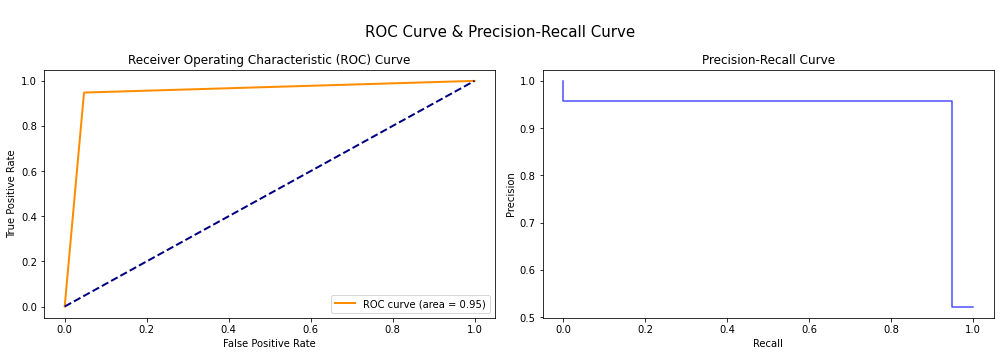

In [15]:
print("--------------- LR FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(logistic_regression_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
logistic_regression_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = logistic_regression_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, logistic_regression_model, Xtrain_ffs, ytrain)

model_results['Logistic Regression FFS'] = results

### Wrapper Method: Backward Feature Selection

--------------- LR BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['menstrual_pain_(dysmenorrhea)', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'pelvic_pain', 'irregular_or_missed_periods', 'back_pain', 'painful_bowel_movements', 'infertility', 'painful_cramps_during_period', 'constipation_or_chronic_constipation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'extreme_or_severe_pain', 'bleeding', 'lower_back_pain', 'ovarian_cysts', 'constant_bleeding', 'ibs-like_symptoms', 'vaginal_painorpressure', 'sharp_or_stabbing_pain', 'bowel_pain', 'cysts_(unspecified)', 'dizziness', 'abnormal_uterine_bleeding', 'fever', 'feeling_sick', 'abdominal_cramps_during_intercourse', 'insomnia_or_sleeplessness', 'loss_of_appetite']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.

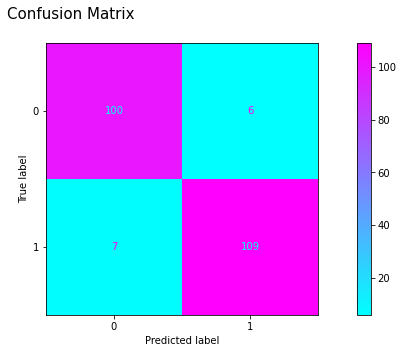

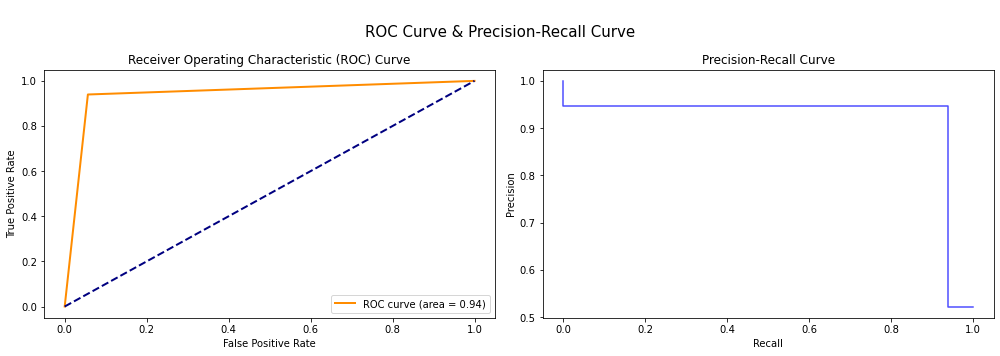

In [16]:
print("--------------- LR BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(logistic_regression_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
logistic_regression_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = logistic_regression_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, logistic_regression_model, Xtrain_bfs, ytrain)

model_results['Logistic Regression BFS'] = results

### Linear Dimentionality Reduction Method: Principal Component Analysis (PCA)

--------------- LR PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pi

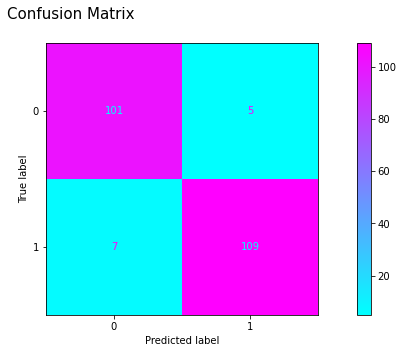

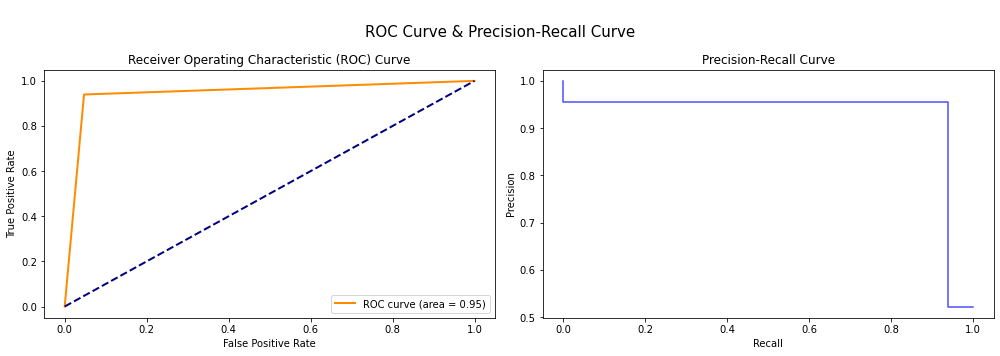

In [17]:
print("--------------- LR PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_lr_model = LogisticRegression(max_iter = 1000)

# Train the model
pca_lr_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_lr_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_lr_model, Xtrain_pca, ytrain)

model_results['Logistic Regression PCA(58)'] = results

--------------- LR PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'loss_of_appetite', 'headaches']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'back_pain', 'cysts_(unspecified)']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pi

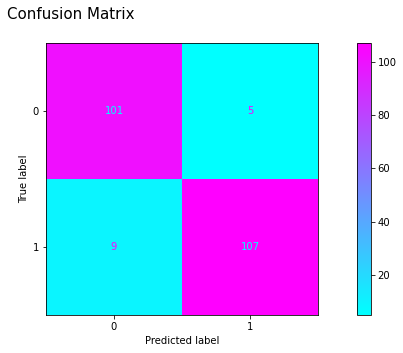

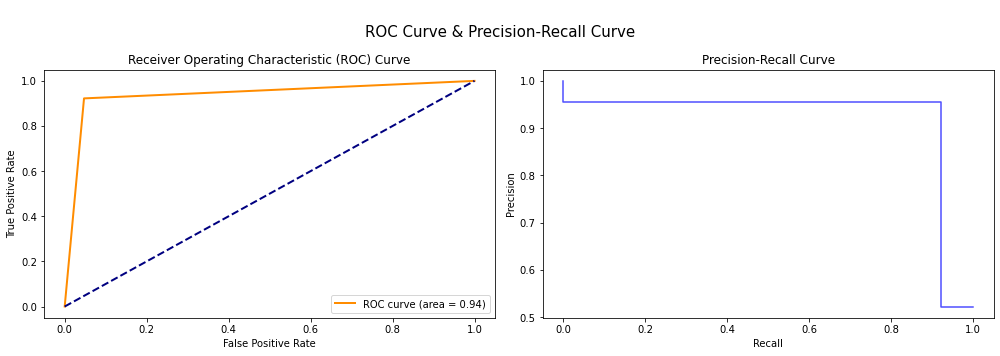

In [18]:
print("--------------- LR PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 29

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_lr_model = LogisticRegression(max_iter = 1000)

# Train the model
pca_lr_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_lr_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_lr_model, Xtrain_pca, ytrain)

model_results['Logistic Regression PCA (29)'] = results

## Random Forest
### Base Model


--------------- Evaluation ---------------
Accuracy: 0.9594594594594594
Precision: 0.9734513274336283
Recall: 0.9482758620689655
F1 Score: 0.9606986899563318
ROC AUC: 0.9599869876382563
Standard Deviaiton (Accuracy): 0.022679000545956125

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.94      0.97      0.96       106
1 - Positive       0.97      0.95      0.96       116

    accuracy                           0.96       222
   macro avg       0.96      0.96      0.96       222
weighted avg       0.96      0.96      0.96       222


--------------- Visual Evaluation ---------------


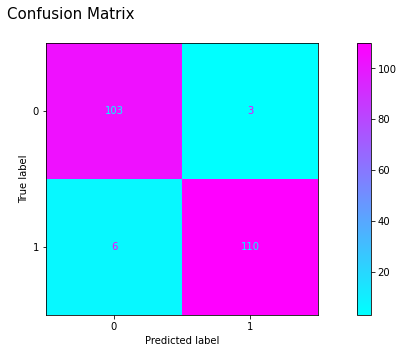

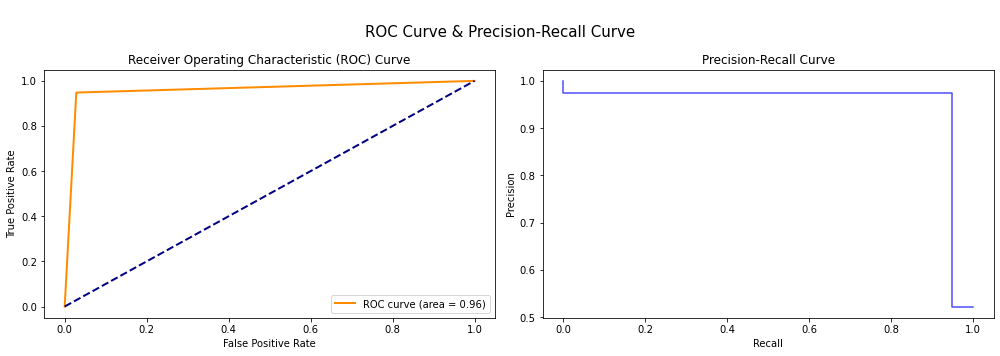

In [24]:
random_forest_model = RandomForestClassifier()

random_forest_model.fit(Xtrain, ytrain)
ypred = random_forest_model.predict(Xtest)

results = evaluate(ytest, ypred, random_forest_model, Xtrain, ytrain)

model_results['Random Forest'] = results

### Wrapper Method: Forward Feature Selection

--------------- RF FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['menstrual_pain_(dysmenorrhea)', 'irregular_or_missed_periods', 'abdominal_pain_or_pressure', 'nausea', 'infertility', 'painful_cramps_during_period', 'constipation_or_chronic_constipation', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'migraines', 'irritable_bowel_syndrome_(ibs)', 'syncope_(fainting,_passing_out)', 'lower_back_pain', 'fertility_issues', 'ovarian_cysts', 'painful_urination', 'digestive_or_gi_problems', 'ibs-like_symptoms', 'hip_pain', 'vaginal_painorpressure', 'sharp_or_stabbing_pain', 'bowel_pain', 'cysts_(unspecified)', 'malaise_or_sickness', 'bloating', 'feeling_sick', 'abdominal_cramps_during_intercourse', 'insomnia_or_sleeplessness', 'loss_of_appetite']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.928
Precision:

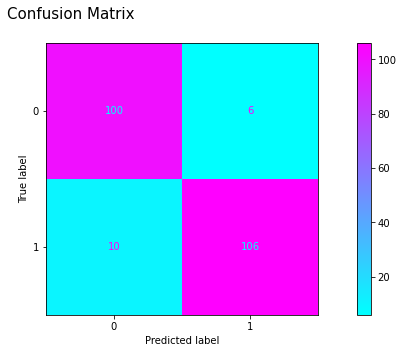

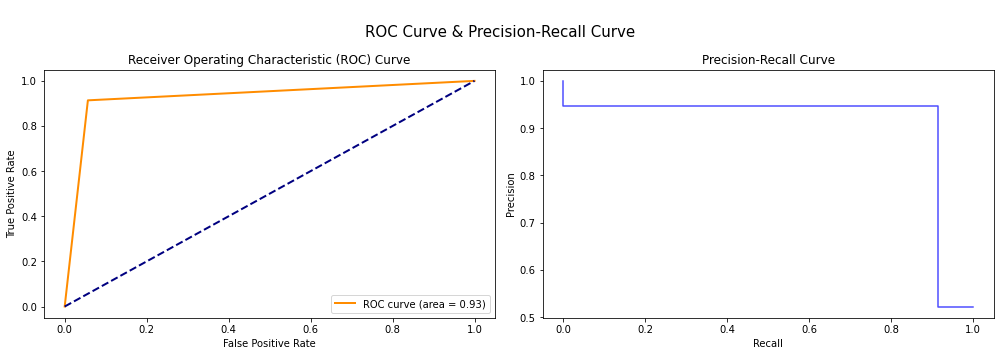

In [20]:
print("--------------- RF FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(random_forest_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
random_forest_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = random_forest_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, random_forest_model, Xtrain_ffs, ytrain)

model_results['Random Forest FFS'] = results

### Wrapper Method: Backward Feature Selection

--------------- RF BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'back_pain', 'painful_bowel_movements', 'infertility', 'pain_or_chronic_pain', 'long_menstruation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'migraines', 'extreme_or_severe_pain', 'leg_pain', 'syncope_(fainting,_passing_out)', 'ovarian_cysts', 'painful_urination', 'headaches', 'pain_after_intercourse', 'ibs-like_symptoms', 'excessive_bleeding', 'hip_pain', 'bowel_pain', 'cysts_(unspecified)', 'fever', 'bloating', 'decreased_energy_or_exhaustion', 'insomnia_or_sleeplessness', 'acne_or_pimples']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.923
Precision: 0.946
Recall: 0.905
F

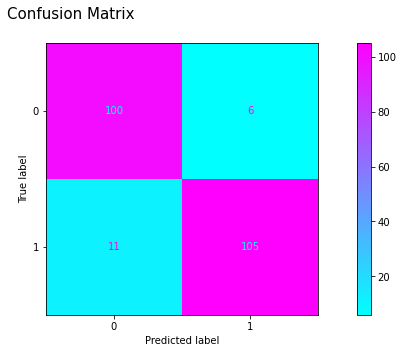

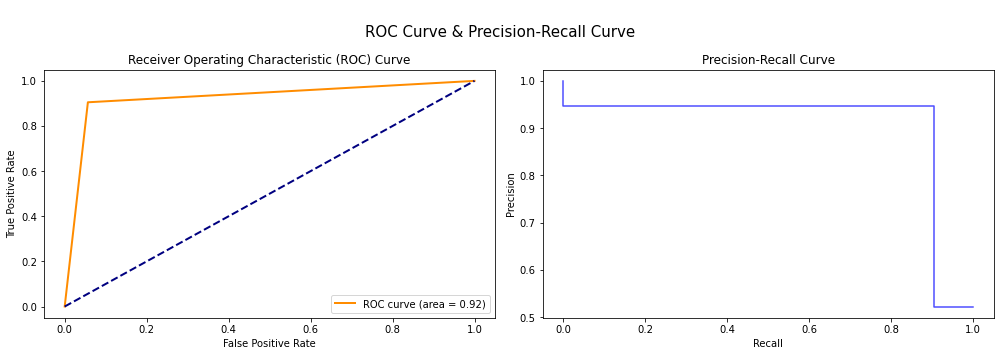

In [21]:
print("--------------- RF BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(random_forest_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
random_forest_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = random_forest_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, random_forest_model, Xtrain_bfs, ytrain)

model_results['Random Forest BFS'] = results

### Linear Dimentionality Reduction Method: Principal Component Analysis (PCA)

--------------- RF PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pi

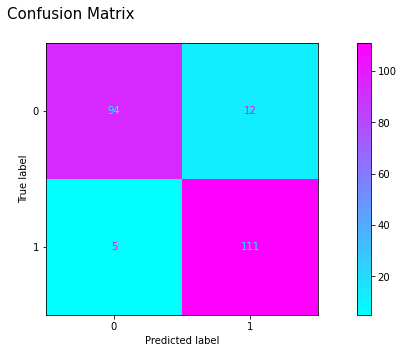

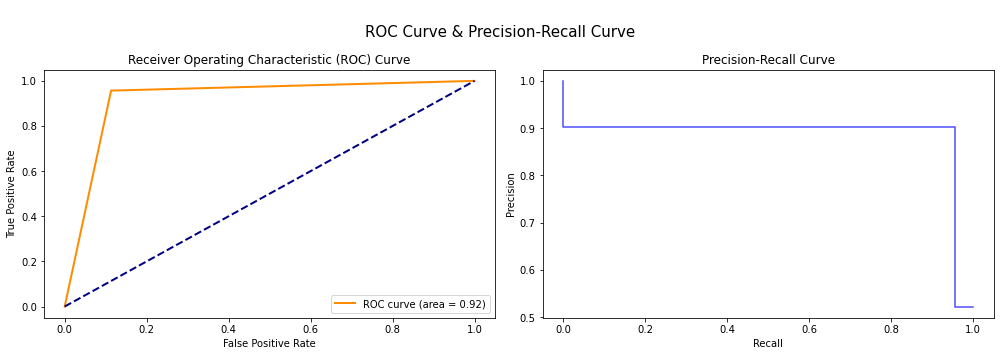

In [22]:
print("--------------- RF PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- Model Training ---------------")

# Initialize the Random Forest model
pca_rf_model = RandomForestClassifier()

# Train the model
pca_rf_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_rf_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_rf_model, Xtrain_pca, ytrain)

model_results['Random Forest PCA(58)'] = results

--------------- RF PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'back_pain', 'cysts_(unspecified)']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pi

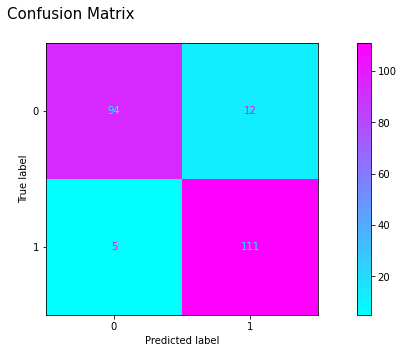

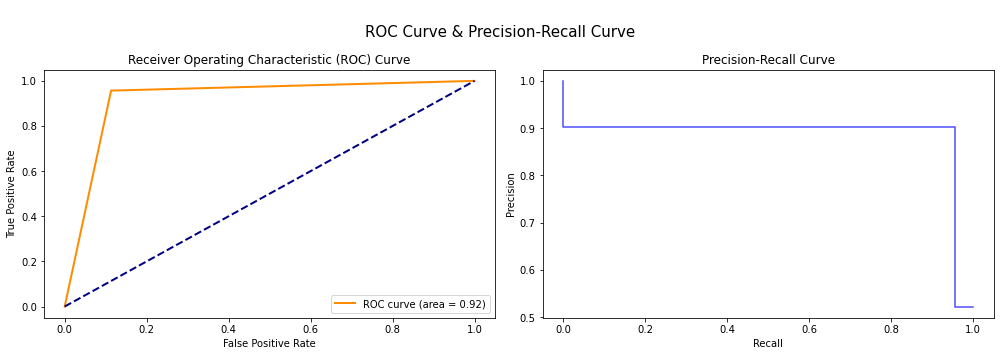

In [23]:
print("--------------- RF PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 29

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_rf_model = RandomForestClassifier()

# Train the model
pca_rf_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_rf_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_rf_model, Xtrain_pca, ytrain)

model_results['Random Forest PCA (29)'] = results

## XGBoost
### Base Model


--------------- Evaluation ---------------
Accuracy: 0.946
Precision: 0.941
Recall: 0.957
F1 Score: 0.949
ROC AUC: 0.945
Standard Deviaiton (Accuracy): 0.0153

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.95      0.93      0.94       106
1 - Positive       0.94      0.96      0.95       116

    accuracy                           0.95       222
   macro avg       0.95      0.95      0.95       222
weighted avg       0.95      0.95      0.95       222


--------------- Visual Evaluation ---------------


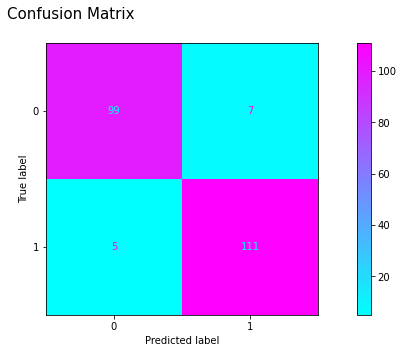

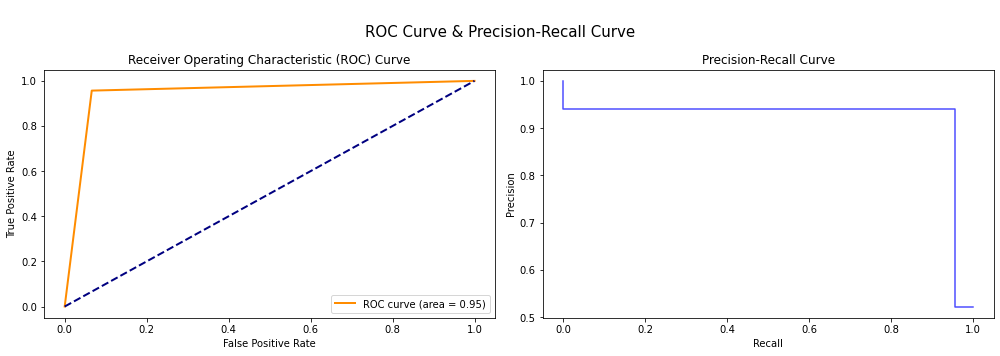

In [24]:
xgboost_model = XGBClassifier()

xgboost_model.fit(Xtrain, ytrain)
ypred = xgboost_model.predict(Xtest)

results = evaluate(ytest, ypred, xgboost_model, Xtrain, ytrain)

model_results['XGBoost'] = results

### Wrapper Method: Forward Feature Selection

--------------- XGB FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'irregular_or_missed_periods', 'cramping', 'painful_bowel_movements', 'infertility', 'painful_cramps_during_period', 'diarrhea', 'long_menstruation', 'fatigue_or_chronic_fatigue', 'stomach_cramping', 'irritable_bowel_syndrome_(ibs)', 'syncope_(fainting,_passing_out)', 'depression', 'bleeding', 'lower_back_pain', 'fertility_issues', 'ovarian_cysts', 'constant_bleeding', 'digestive_or_gi_problems', 'ibs-like_symptoms', 'excessive_bleeding', 'anaemia_or_iron_deficiency', 'hip_pain', 'vaginal_painorpressure', 'sharp_or_stabbing_pain', 'cysts_(unspecified)', 'fever', 'loss_of_appetite']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.919
Precision: 0.922
Recall: 0.922
F1 Scor

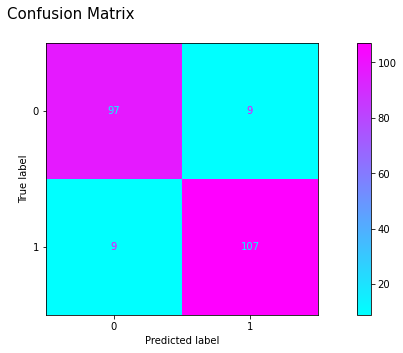

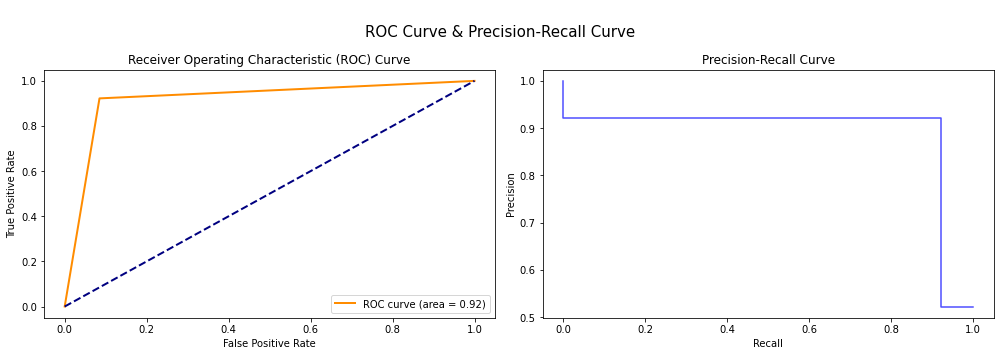

In [25]:
print("--------------- XGB FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(xgboost_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
xgboost_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = xgboost_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, xgboost_model, Xtrain_ffs, ytrain)

model_results['XGBoost FFS'] = results


### Wrapper Method: Backward Feature Selection

--------------- XGB BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'irregular_or_missed_periods', 'cramping', 'abdominal_pain_or_pressure', 'painful_bowel_movements', 'infertility', 'painful_cramps_during_period', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'extreme_or_severe_pain', 'leg_pain', 'bleeding', 'ovarian_cysts', 'headaches', 'constant_bleeding', 'excessive_bleeding', 'vaginal_painorpressure', 'bowel_pain', 'cysts_(unspecified)', 'abnormal_uterine_bleeding', 'fever', 'hormonal_problems', 'bloating', 'decreased_energy_or_exhaustion', 'abdominal_cramps_during_intercourse', 'loss_of_appetite']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy

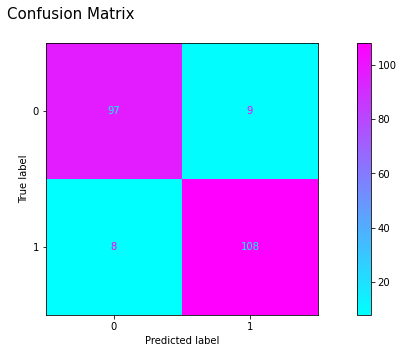

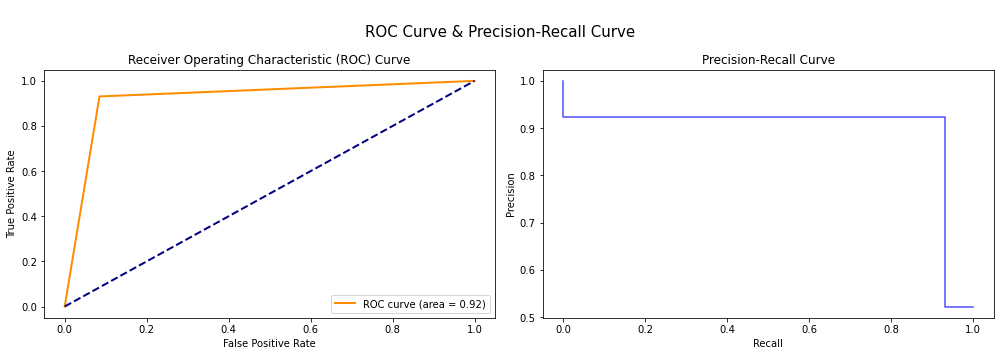

In [26]:
print("--------------- XGB BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(xgboost_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
xgboost_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = xgboost_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, xgboost_model, Xtrain_bfs, ytrain)

model_results['XGBoost BFS'] = results

### Linear Dimentionality Reduction Method: Principal Component Analysis (PCA)

--------------- XGB PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_p

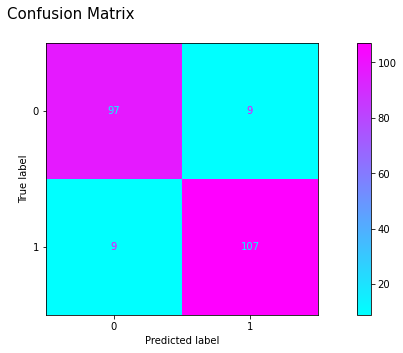

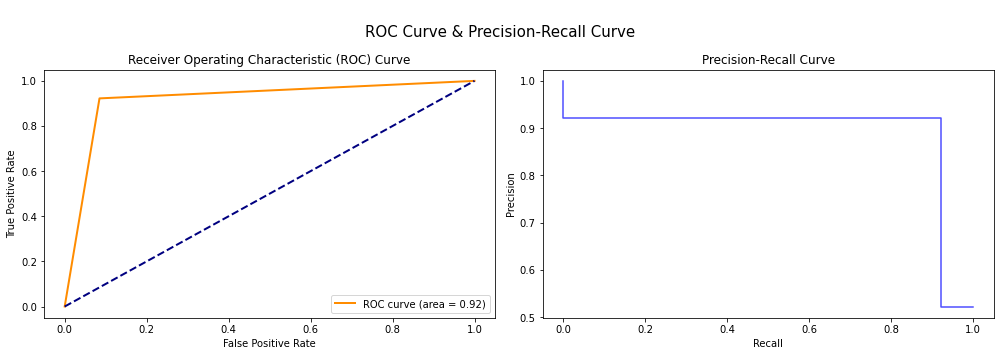

In [27]:
print("--------------- XGB PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_xgb_model = XGBClassifier()

# Train the model
pca_xgb_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_xgb_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_xgb_model, Xtrain_pca, ytrain)

model_results['XGBoost PCA(58)'] = results

--------------- XGB PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'infertility']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'ovarian_cysts']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pi

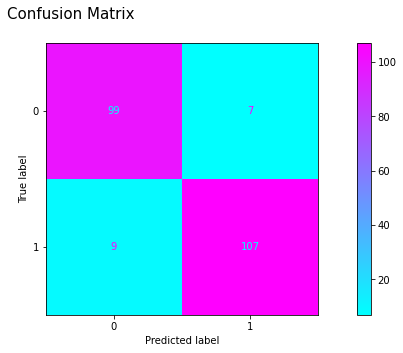

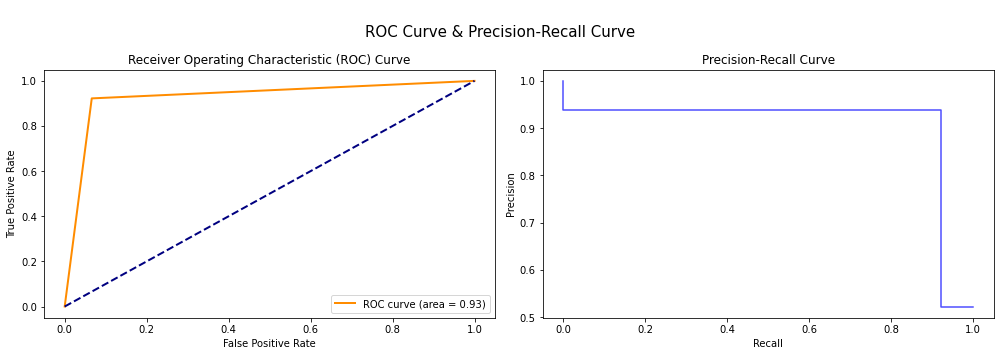

In [28]:
print("--------------- XGB PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 29

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_xgb_model = XGBClassifier()

# Train the model
pca_xgb_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_xgb_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_xgb_model, Xtrain_pca, ytrain)

model_results['XGBoost PCA (29)'] = results

## Decision Tree
### Base Model


--------------- Evaluation ---------------
Accuracy: 0.914
Precision: 0.915
Recall: 0.922
F1 Score: 0.918
ROC AUC: 0.914
Standard Deviaiton (Accuracy): 0.00354

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.91      0.91      0.91       106
1 - Positive       0.91      0.92      0.92       116

    accuracy                           0.91       222
   macro avg       0.91      0.91      0.91       222
weighted avg       0.91      0.91      0.91       222


--------------- Visual Evaluation ---------------


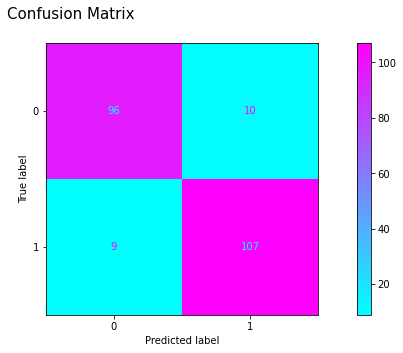

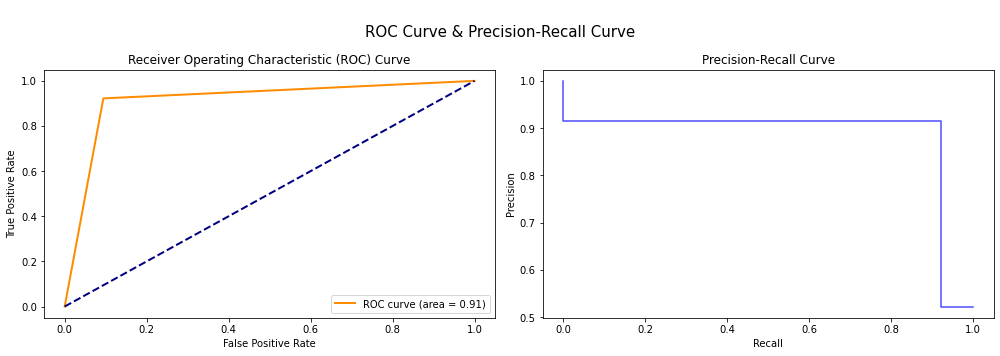

In [29]:
decision_tree_model = DecisionTreeClassifier()

decision_tree_model.fit(Xtrain, ytrain)
ypred = decision_tree_model.predict(Xtest)

results = evaluate(ytest, ypred, decision_tree_model, Xtrain, ytrain)

model_results['Decision Tree'] = results

### Wrapper Method: Forward Feature Selection

--------------- DT FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['menstrual_pain_(dysmenorrhea)', 'cramping', 'back_pain', 'painful_bowel_movements', 'menstrual_clots', 'infertility', 'painful_cramps_during_period', 'pain_or_chronic_pain', 'long_menstruation', 'vomiting_or_constant_vomiting', 'extreme_or_severe_pain', 'irritable_bowel_syndrome_(ibs)', 'syncope_(fainting,_passing_out)', 'lower_back_pain', 'fertility_issues', 'ovarian_cysts', 'constant_bleeding', 'pain_after_intercourse', 'ibs-like_symptoms', 'anaemia_or_iron_deficiency', 'hip_pain', 'vaginal_painorpressure', 'sharp_or_stabbing_pain', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'fever', 'bloating', 'decreased_energy_or_exhaustion', 'abdominal_cramps_during_intercourse']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.851
Precision: 0

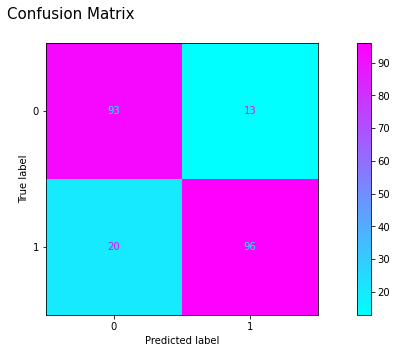

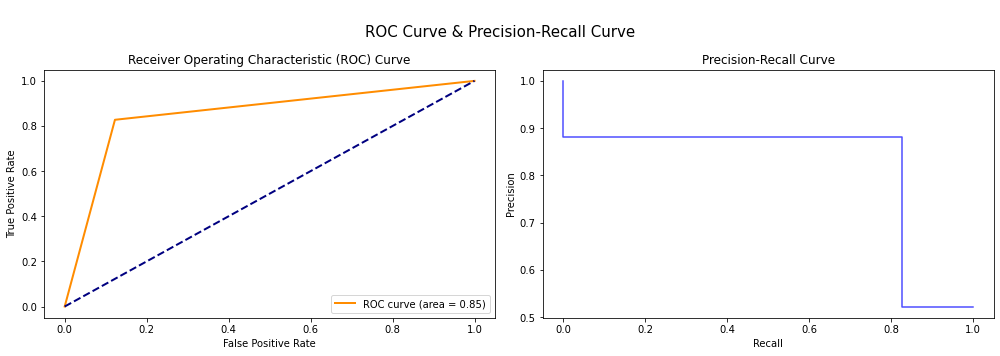

In [30]:
print("--------------- DT FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(decision_tree_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
decision_tree_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = decision_tree_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, decision_tree_model, Xtrain_ffs, ytrain)

model_results['Decision Tree FFS'] = results

### Wrapper Method: Backward Feature Selection

--------------- DT BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['menstrual_pain_(dysmenorrhea)', 'pelvic_pain', 'cramping', 'abdominal_pain_or_pressure', 'back_pain', 'painful_bowel_movements', 'infertility', 'painful_cramps_during_period', 'diarrhea', 'constipation_or_chronic_constipation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'migraines', 'extreme_or_severe_pain', 'leg_pain', 'irritable_bowel_syndrome_(ibs)', 'syncope_(fainting,_passing_out)', 'depression', 'bleeding', 'headaches', 'constant_bleeding', 'digestive_or_gi_problems', 'ibs-like_symptoms', 'anxiety', 'cysts_(unspecified)', 'dizziness', 'abnormal_uterine_bleeding', 'fever', 'abdominal_cramps_during_intercourse']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.892
Precision: 0.897
Recall: 0.897
F1 Score: 0.897
ROC AU

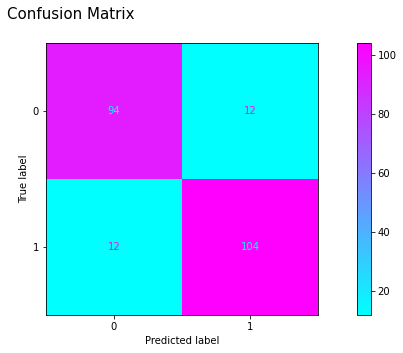

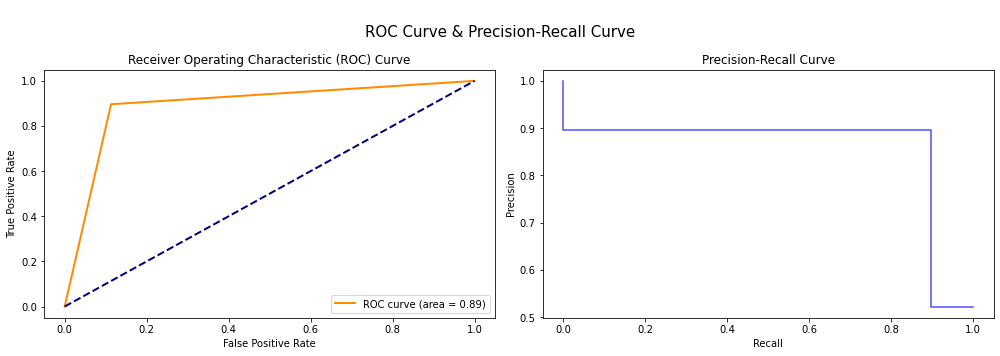

In [31]:
print("--------------- DT BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(decision_tree_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
decision_tree_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = decision_tree_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, decision_tree_model, Xtrain_bfs, ytrain)

model_results['Decision Tree BFS'] = results

### Linear Dimentionality Reduction Method: Principal Component Analysis (PCA)

--------------- DT PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pi

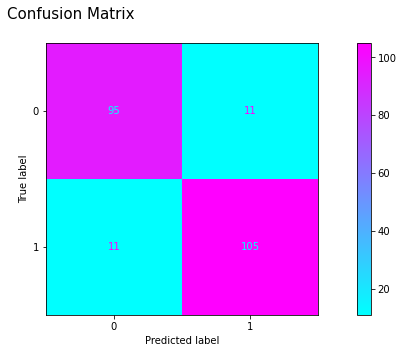

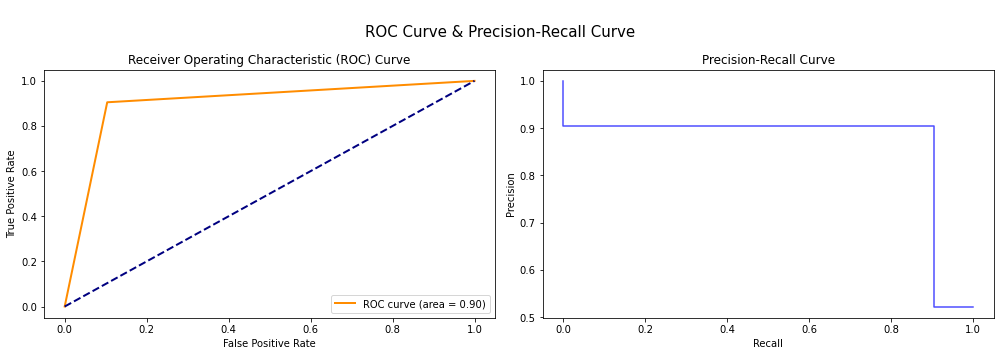

In [32]:
print("--------------- DT PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_dt_model = DecisionTreeClassifier()

# Train the model
pca_dt_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_dt_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_dt_model, Xtrain_pca, ytrain)

model_results['Decision Tree PCA(58)'] = results

--------------- DT PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'infertility']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pimples

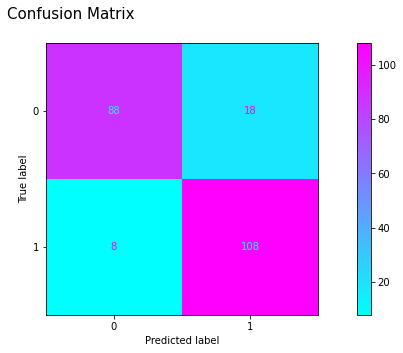

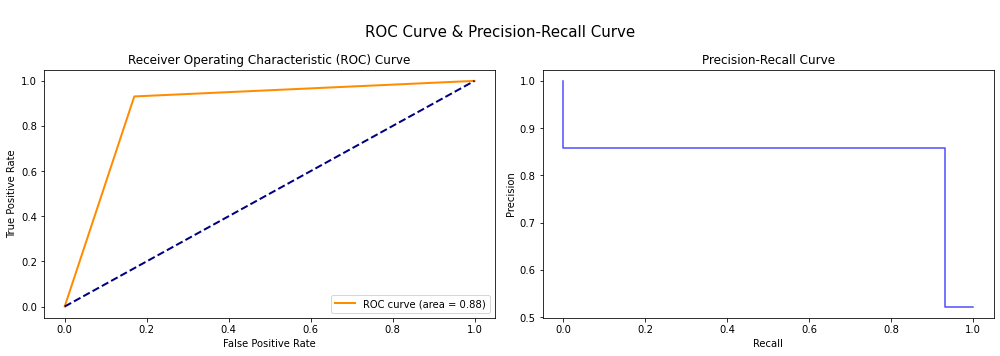

In [33]:
print("--------------- DT PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 29

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_dt_model = DecisionTreeClassifier()

# Train the model
pca_dt_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_dt_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_dt_model, Xtrain_pca, ytrain)

model_results['Decision Tree PCA (29)'] = results

## Support Vector Machine (SVM)
### Base Model


--------------- Evaluation ---------------
Accuracy: 0.905
Precision: 0.886
Recall: 0.94
F1 Score: 0.912
ROC AUC: 0.904
Standard Deviaiton (Accuracy): 0.0195

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.93      0.87      0.90       106
1 - Positive       0.89      0.94      0.91       116

    accuracy                           0.91       222
   macro avg       0.91      0.90      0.90       222
weighted avg       0.91      0.91      0.91       222


--------------- Visual Evaluation ---------------


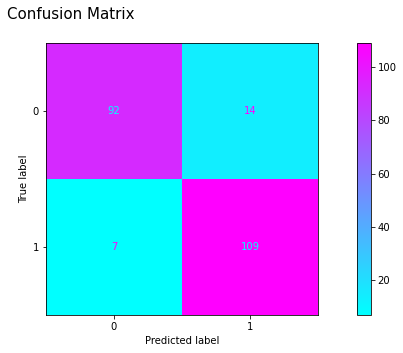

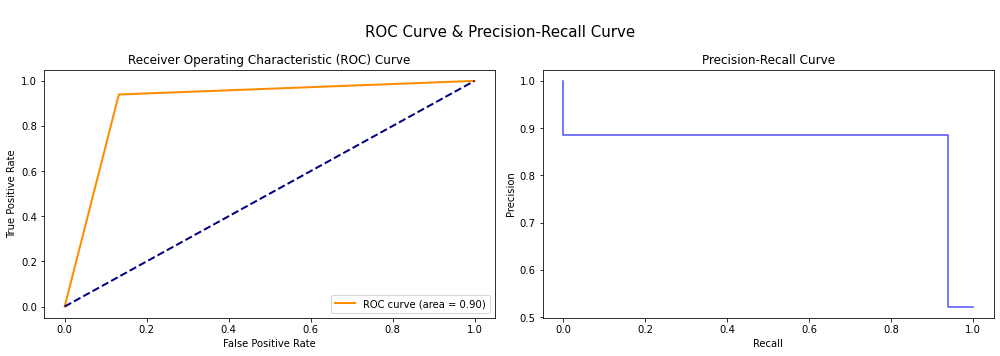

In [34]:
svm_model = svm.SVC(kernel='linear')

svm_model.fit(Xtrain, ytrain)
ypred = svm_model.predict(Xtest)

results = evaluate(ytest, ypred, svm_model, Xtrain, ytrain)

model_results['SVM'] = results

### Wrapper Method: Forward Feature Selection

--------------- SVM FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'pelvic_pain', 'irregular_or_missed_periods', 'cramping', 'back_pain', 'painful_bowel_movements', 'painful_cramps_during_period', 'long_menstruation', 'constipation_or_chronic_constipation', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'migraines', 'extreme_or_severe_pain', 'irritable_bowel_syndrome_(ibs)', 'mood_swings', 'bleeding', 'fertility_issues', 'ovarian_cysts', 'painful_urination', 'constant_bleeding', 'digestive_or_gi_problems', 'excessive_bleeding', 'anaemia_or_iron_deficiency', 'bowel_pain', 'malaise_or_sickness', 'fever', 'decreased_energy_or_exhaustion', 'acne_or_pimples']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.923
Precision: 0.896
Recall: 0.

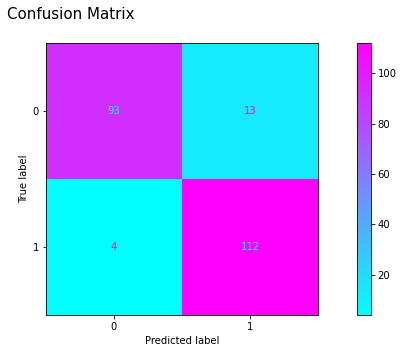

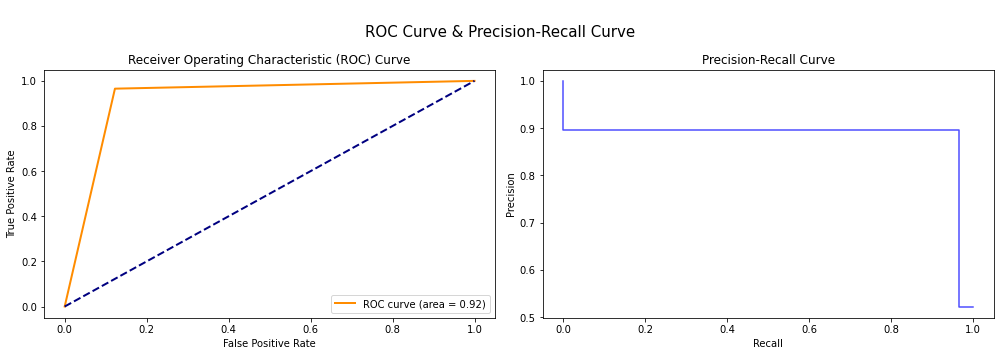

In [35]:
print("--------------- SVM FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(svm_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
svm_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = svm_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, svm_model, Xtrain_ffs, ytrain)

model_results['SVM FFS'] = results

### Wrapper Method: Backward Feature Selection

--------------- SVM BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'pelvic_pain', 'irregular_or_missed_periods', 'cramping', 'abdominal_pain_or_pressure', 'painful_bowel_movements', 'infertility', 'long_menstruation', 'constipation_or_chronic_constipation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'mood_swings', 'bleeding', 'fertility_issues', 'ovarian_cysts', 'headaches', 'constant_bleeding', 'digestive_or_gi_problems', 'ibs-like_symptoms', 'bowel_pain', 'cysts_(unspecified)', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'fever', 'abdominal_cramps_during_intercourse', 'loss_of_appetite']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 

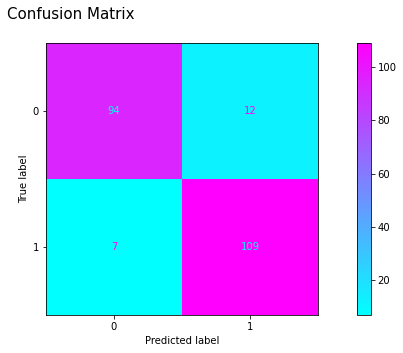

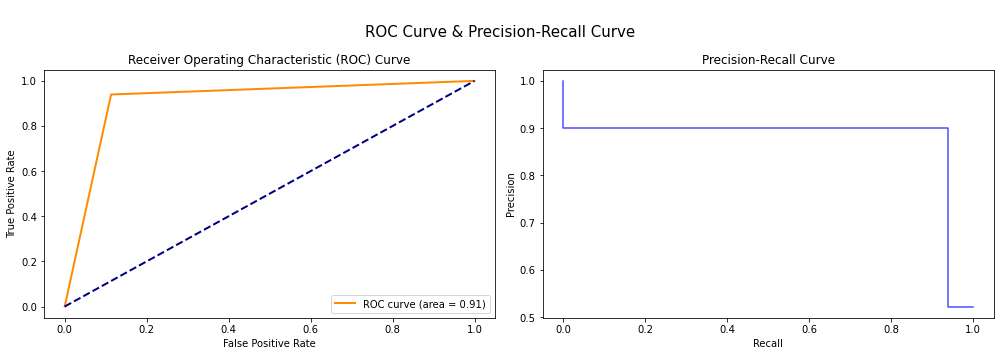

In [36]:
print("--------------- SVM BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(svm_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
svm_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = svm_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, svm_model, Xtrain_bfs, ytrain)

model_results['SVM BFS'] = results

### Linear Dimentionality Reduction Method: Principal Component Analysis (PCA)

--------------- SVM PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_p

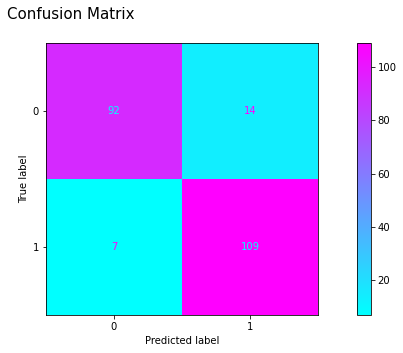

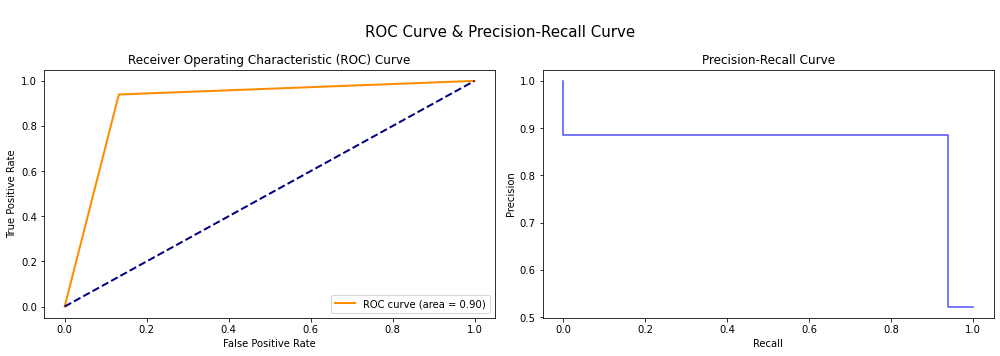

In [37]:
print("--------------- SVM PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_svm_model = svm.SVC(kernel='linear')

# Train the model
pca_svm_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_svm_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_svm_model, Xtrain_pca, ytrain)

model_results['SVM PCA(58)'] = results

--------------- SVM PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'infertility']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'back_pain', 'cysts_(unspecified)']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pimple

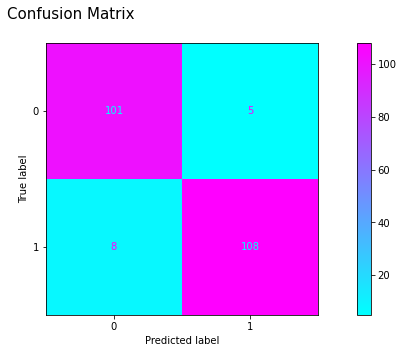

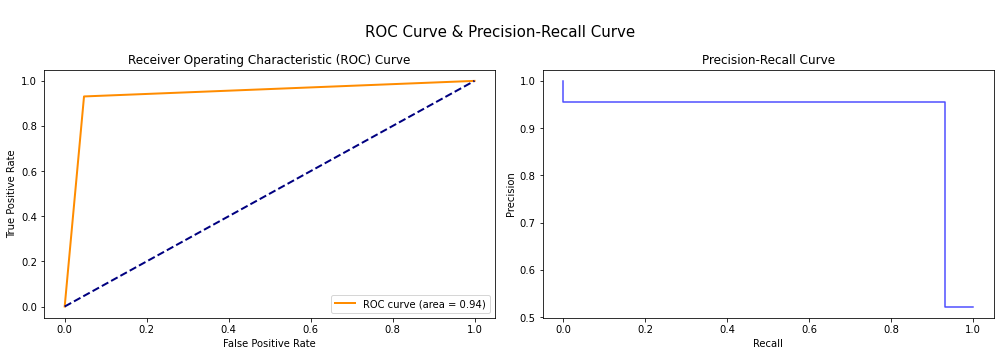

In [38]:
print("--------------- SVM PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 29

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_svm_model = svm.SVC(kernel='linear')

# Train the model
pca_svm_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_svm_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_svm_model, Xtrain_pca, ytrain)

model_results['SVM PCA (29)'] = results

## Adaboost
### Base Model


--------------- Evaluation ---------------
Accuracy: 0.932
Precision: 0.917
Recall: 0.957
F1 Score: 0.937
ROC AUC: 0.931
Standard Deviaiton (Accuracy): 0.0101

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.95      0.91      0.93       106
1 - Positive       0.92      0.96      0.94       116

    accuracy                           0.93       222
   macro avg       0.93      0.93      0.93       222
weighted avg       0.93      0.93      0.93       222


--------------- Visual Evaluation ---------------


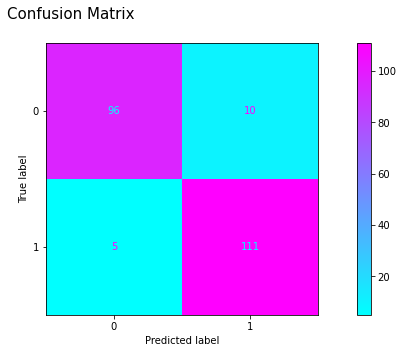

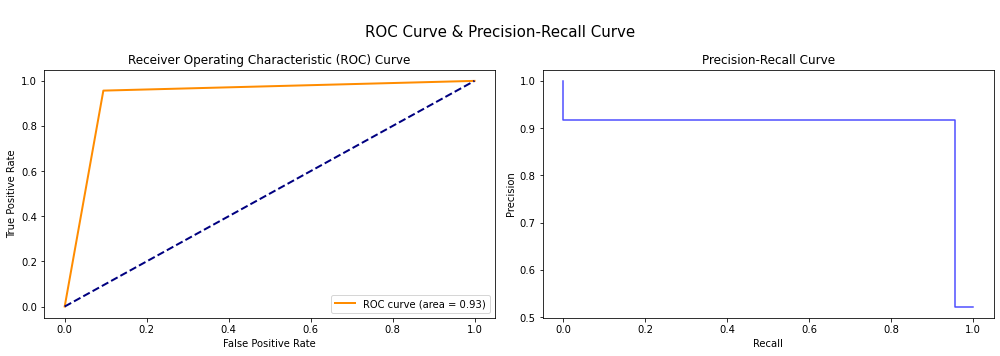

In [39]:
adaboost_model = AdaBoostClassifier()

adaboost_model.fit(Xtrain, ytrain)
ypred = adaboost_model.predict(Xtest)

results = evaluate(ytest, ypred, adaboost_model, Xtrain, ytrain)

model_results['AdaBoost'] = results

### Wrapper Method: Forward Feature Selection

--------------- Adaboost FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'painful_bowel_movements', 'nausea', 'menstrual_clots', 'painful_cramps_during_period', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'stomach_cramping', 'extreme_or_severe_pain', 'leg_pain', 'depression', 'bleeding', 'lower_back_pain', 'fertility_issues', 'ovarian_cysts', 'constant_bleeding', 'pain_after_intercourse', 'digestive_or_gi_problems', 'excessive_bleeding', 'anaemia_or_iron_deficiency', 'vaginal_painorpressure', 'sharp_or_stabbing_pain', 'anxiety', 'dizziness', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'decreased_energy_or_exhaustion', 'abdominal_cramps_during_intercourse']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.946
Precision: 0.94

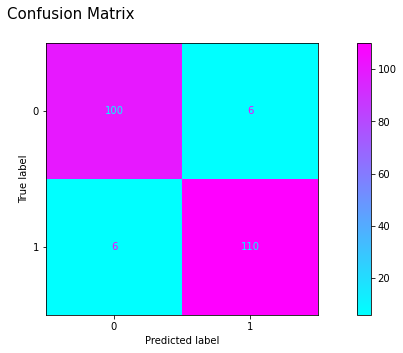

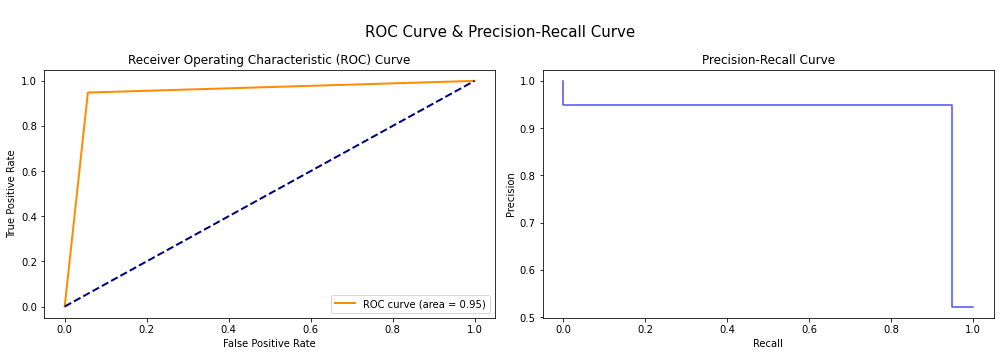

In [40]:
print("--------------- Adaboost FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(adaboost_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
adaboost_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = adaboost_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, adaboost_model, Xtrain_ffs, ytrain)

model_results['Adaboost FFS'] = results

### Wrapper Method: Backward Feature Selection

--------------- Adaboost BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['menstrual_pain_(dysmenorrhea)', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'pelvic_pain', 'irregular_or_missed_periods', 'cramping', 'back_pain', 'painful_bowel_movements', 'painful_cramps_during_period', 'pain_or_chronic_pain', 'constipation_or_chronic_constipation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'mood_swings', 'bleeding', 'fertility_issues', 'ovarian_cysts', 'headaches', 'constant_bleeding', 'ibs-like_symptoms', 'bowel_pain', 'cysts_(unspecified)', 'dizziness', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'fever', 'hormonal_problems', 'abdominal_cramps_during_intercourse', 'loss_of_appetite']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.923
Precision: 0.909
Re

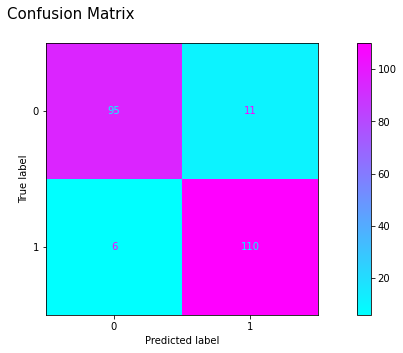

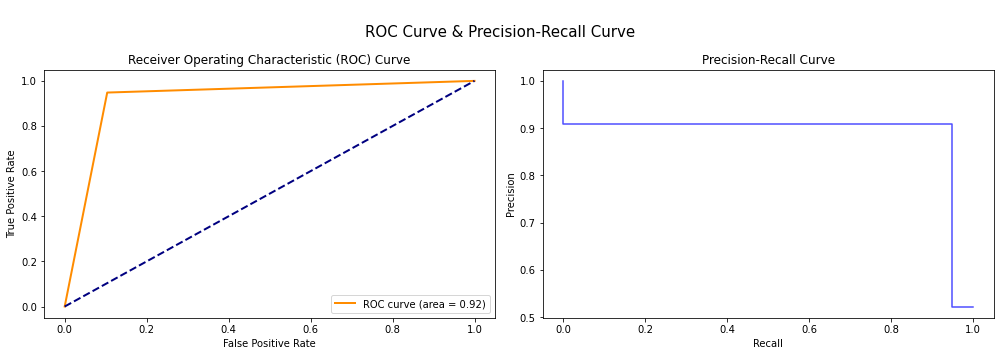

In [41]:
print("--------------- Adaboost BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(adaboost_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
adaboost_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = adaboost_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, adaboost_model, Xtrain_bfs, ytrain)

model_results['Adaboost BFS'] = results

### Linear Dimentionality Reduction Method: Principal Component Analysis (PCA)

--------------- LR PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pi

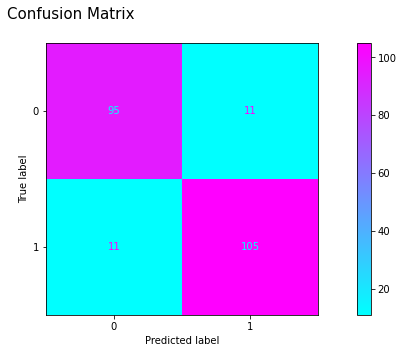

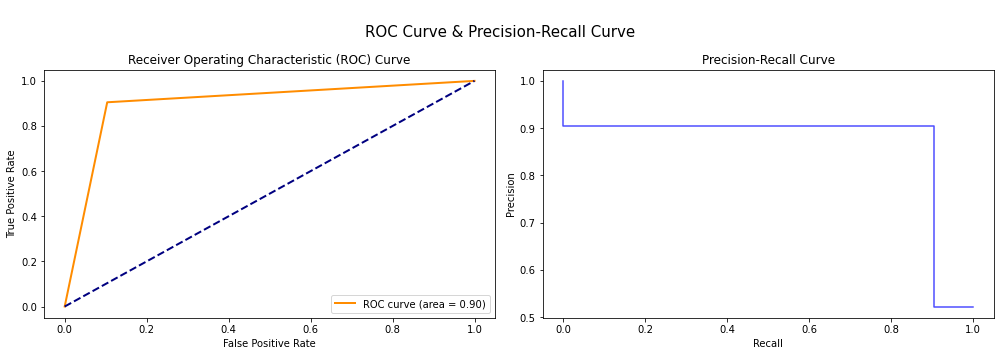

In [42]:
print("--------------- LR PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_adaboost_model = AdaBoostClassifier()

# Train the model
pca_adaboost_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_adaboost_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_adaboost_model, Xtrain_pca, ytrain)

model_results['Adaboost PCA(58)'] = results

--------------- Adaboost PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'loss_of_appetite', 'headaches']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne

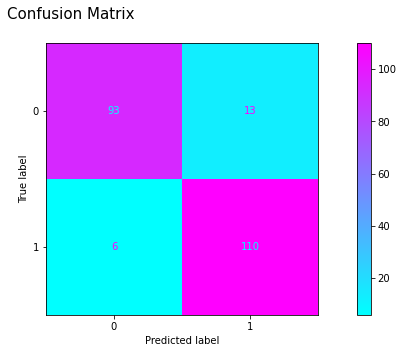

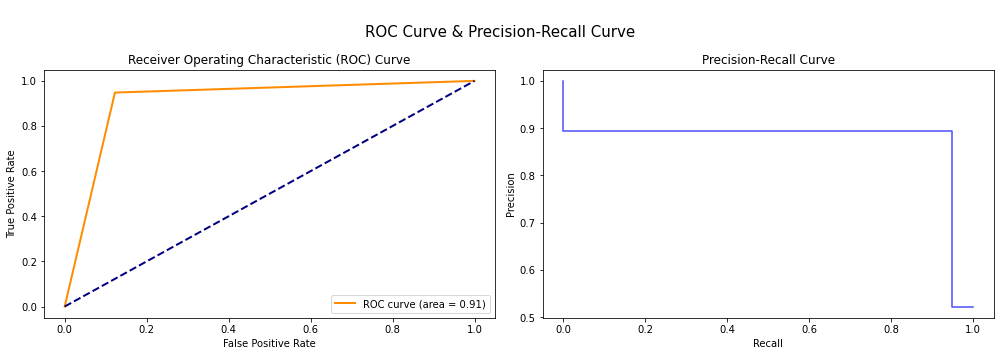

In [43]:
print("--------------- Adaboost PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 29

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_adaboost_model = AdaBoostClassifier()

# Train the model
pca_adaboost_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_adaboost_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_adaboost_model, Xtrain_pca, ytrain)

model_results['Adaboost PCA (29)'] = results

## Model Results

In [44]:
model_results.head(6)

,Metrics,Logistic Regression,Logistic Regression FFS,Logistic Regression BFS,Logistic Regression PCA(58),Logistic Regression PCA (29),Random Forest,Random Forest FFS,Random Forest BFS,Random Forest PCA(58),...,SVM,SVM FFS,SVM BFS,SVM PCA(58),SVM PCA (29),AdaBoost,Adaboost FFS,Adaboost BFS,Adaboost PCA(58),Adaboost PCA (29)
0,Accuracy,0.945946,0.950450,0.941441,0.945946,0.936937,0.936937,0.927928,0.923423,0.923423,...,0.905405,0.923423,0.914414,0.905405,0.941441,0.932432,0.945946,0.923423,0.900901,0.914414
1,Precision,0.956140,0.956522,0.947826,0.956140,0.955357,0.963636,0.946429,0.945946,0.902439,...,0.886179,0.896000,0.900826,0.886179,0.955752,0.917355,0.948276,0.909091,0.905172,0.894309
2,Recall,0.939655,0.948276,0.939655,0.939655,0.922414,0.913793,0.913793,0.905172,0.956897,...,0.939655,0.965517,0.939655,0.939655,0.931034,0.956897,0.948276,0.948276,0.905172,0.948276
3,F1Score,0.947826,0.952381,0.943723,0.947826,0.938596,0.938053,0.929825,0.925110,0.928870,...,0.912134,0.929461,0.919831,0.912134,0.943231,0.936709,0.948276,0.928270,0.905172,0.920502
4,ROC AUC,0.946243,0.950553,0.941526,0.946243,0.937622,0.938029,0.928595,0.924284,0.921845,...,0.903790,0.921438,0.913224,0.903790,0.941932,0.931278,0.945836,0.922251,0.900699,0.912817
5,Standard Dev,0.008241,0.023512,0.023946,0.008241,0.022764,0.008241,0.011301,0.015989,0.030718,...,0.019525,0.022041,0.012541,0.019525,0.022311,0.010142,0.014171,0.023120,0.018461,0.029952


In [45]:
model_results.to_csv('../results/clinical_model_results.csv', index=True)  